# Decision Tree

In [72]:
import os
import math
import time
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from scipy.io import loadmat
from numpy.matlib import repmat

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib notebook

## Generate Data

We generate a **spiral** dataset with **binary** output labels:

In [65]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    return xTr, yTr, xTe, yTe

xTrSpiral, yTrSpiral, xTeSpiral, yTeSpiral = spiraldata(150)

## Define the Tree Node

A decision tree is constructured by distinct **nodes** and **leaves**.

**`Leaves`** have two fields: 

1. **parent**: another node
2. **prediction**: numerical value

**`Nodes`** have six fields:

1. **left**: node describing left subtree
2. **right**: node describing right subtree
3. **parent**: the parent of the current subtree. The head of the tree always has **None** as its parent.
4. **cutoff_id**: index of feature to cut
5. **cutoff_value**: cutoff value c ($\leq c$: left, $>c$: right)
6. **prediction**: scalar prediction at this node

In [66]:
class TreeNode(object):
    
    """
    Tree class.
    """
    
    def __init__(self, left, right, parent, cutoff_id, cutoff_val, prediction):
        self.left = left
        self.right = right
        self.parent = parent
        self.cutoff_id = cutoff_id
        self.cutoff_val = cutoff_val
        self.prediction = prediction

## Find the Optimal Split Efficiently

> First, we implement a function **`sqsplit`** which takes as input a **weighted dataset with labels** and computes the **feature** and **cut-value** of an **optimal split** based on **minimum squared error**.
>
>The **loss** to be minimized is the **average weighted sqaured-loss**:
>
>$${\cal L}(S)=\sum_{i \in L} {w_{i}(y_{i} - T_{L})}^2+\sum_{i \in R} {w_{i}(y_{i} - T_{R})}^2.\label{q2:loss}$$
>
>where $w_i$ are the **normalized weights** of the data points (i.e. $\sum_{i} w_{i} = 1$).

>Suppose we split the dataset on some **feature** $j$ with **value** $c$, then we have two sets of indices:
>
>$L$: the set of indices on the left, $i \in L \Rightarrow [x_{i}]_{j} \leq c$
>
>$R$: the set of indices on the right, $i \in R \Rightarrow [x_{i}]_{j} > c$
>

>Now, we have to try all the optimal split. The first thing is to **sort the training points** in the order of feature $j$ such that $[x_{1}]_{j} < [x_{2}]_{j} < \cdots < [x_{n}]_{j}$. Then, the **possible splits** are $c_{1} \leq c_{2} \leq \cdots \leq c_{n-1}$ where $c_{i}=\frac{[x_{i}]_{j}+[x_{i+1}]_{j}}{2}$.

>However, trying out all these splits are **time consuming**. For $n$ training data points, there are $O(n)$ **splits** with each split requiring $O(n)$ **to evaluate** $\cal L$, resulting in a total **complexity of** $O(n^2)$.

>We can make the algorithm more efficient by using **precomputed quantities**. Suppose some **split** $c_k$ results in two sets of data $L^{(k)}$ and $R^{(k)}$. We precompute the following: $W_{L^{(k)}}$, $P_{L^{(k)}} = \sum_{i \in L} w_{i}y_{i}$, and $Q_{L^{(k)}} = \sum_{i \in L} w_{i}y_{i}^{2}$. Similarly, we also precompute: $W_{R^{(k)}}$, $P_{R^{(k)}}$ and $Q_{R^{(k)}}$.

>If all feature values are distinct, only **one data point** moves from $R$ to $L$ when moving from split $k$ to split $k+1$. Therefore, we only need to update the **precomputed** values accordingly when trying the **next split**.
>
>For example:
>
>1. we subtract $w_k$ from $W_{R^{(k)}}$ and add it to $W_{L^{(k)}}$
>2. we subtract $w_{k}y_{k}$ from $P_{R^{(k)}}$ and add it to $P_{L^{(k)}}$
>3. We subtract $w_{k}y_{k}^{2}$ from $Q_{R^{(k)}}$ and add it to $Q_{L^{(k)}}$
>
>All of these updates take only **constant time**.

>We these precomputed values, we can express the first term of the **loss $\cal L$** as: 
>$$\sum_{i \in L} {w_{i}(y_{i} - T_{L})}^2 = \sum_{i \in L}w_{i}y_{i}^{2} - 2\sum_{i \in L}w_{i}y_{i}T_{L} + \sum_{i \in L}w_{i}T_{L}^{2}=Q_{L^{(k)}}-\frac{P_{L^{(k)}}^{2}}{w_{L^{(k)}}}$$
>
>Similarly, the second term can be expressed as:
>$$Q_{R^{(k)}}-\frac{P_{R^{(k)}}^{2}}{w_{R^{(k)}}}$$
>
>Thus the loss function becomes:
>
>$${\cal L}(S)=Q_{L^{(k)}}-\frac{P_{L^{(k)}}^{2}}{w_{L^{(k)}}}+Q_{R^{(k)}}-\frac{P_{R^{(k)}}^{2}}{w_{R^{(k)}}}$$

In [62]:
def sqsplit(xTr, yTr, weights=[]):
    """
    Gievn the dataset, finds the best feature, cut value, and loss value.
    Input:
        xTr:     n x d matrix of data points
        yTr:     n-dimensional vector of labels
        weights: n-dimensional weight vector for data points
    Output:
        feature:  index of the best cut's feature
        cut:      cut-value of the best cut
        bestloss: loss of the best cut
    """
    
    N, D = xTr.shape
    assert D > 0 #must have at least one dimension
    assert N > 1 #must have at least two samples
    
    if weights == []: #if no weights are passed on, assign uniform weights
        weights = np.ones(N)
    weights = weights/sum(weights) #Weights need to sum to one (we just normalize them)
    
    bestloss = np.inf
    feature = np.inf
    cut = np.inf
    
    for j in range(D):      #splitting on feature j
        idx = np.argsort(xTr[:,j])     #sort the points in order of feature j
        X = xTr[idx]
        y = yTr[idx]
        weights_sorted = weights[idx]
        first_split = True
        for i in range(N-1):
            if X[i][j] == X[i+1][j]:   #skip the current split if equal
                continue
            else:
                if first_split:     
                    #initialize the precomputed quantities
                    W_L = np.sum(weights_sorted[:i+1])
                    P_L = weights_sorted[:i+1].dot(y[:i+1])
                    Q_L = weights_sorted[:i+1].dot(y[:i+1]**2)
                    W_R = np.sum(weights_sorted[i+1:])
                    P_R = weights_sorted[i+1:].dot(y[i+1:])
                    Q_R = weights_sorted[i+1:].dot(y[i+1:]**2) 
                    first_split = False
                else:
                    #update the precomputed quantities
                    W_L += weights_sorted[i] 
                    P_L += weights_sorted[i] * y[i]
                    Q_L += weights_sorted[i] * y[i]**2
                    W_R -= weights_sorted[i]
                    P_R -= weights_sorted[i] * y[i]
                    Q_R -= weights_sorted[i] * y[i]**2
                loss = (Q_L - P_L**2/W_L) + (Q_R - P_R**2/W_R)    #compute the loss
                if loss < bestloss:
                    bestloss = loss                 #update the best loss 
                    feature = j                     #update the best feature
                    cut = (X[i][j]+X[i+1][j])/2     #update the best cut

    return feature, cut, bestloss

## CART Tree

Now, we implement a function **`cart`** which returns a **regression tree** based on the **minimum squared loss** splitting rule.

The inputs of the function are:

1. training data
2. test data
3. maximum depth (default = infinity)
4. weights of the training data (default = equally weighted)

where the last two are **optional arguments**.

Note, the nature of CART trees implies that every node has **exactly 0 or 2 children**.

In [67]:
def cart(xTr, yTr, depth=np.inf, weights=None):
    """
    Builds a CART tree.
    Input:
        xTr:      n x d matrix of data
        yTr:      n-dimensional vector
        depth:    maximum tree depth
        weights:  n-dimensional weight vector for data points
    Output:
        tree: root of decision tree
    """
    n, d = xTr.shape
    
    #initialize the weights
    if weights is None:
        w = np.ones(n) / float(n)
    else:
        w = weights

    #base cases indicating that we have a leaf node:
    #maximum depth reached
    #number of points left less than 2
    #all the points left have the same lebel
    if depth == 1 or yTr.shape[0] < 2 or np.all(yTr==yTr[0]):
        return TreeNode(None, None, None, None, None, w.dot(yTr))

    #compute the best split at the current node
    feature, cut, bestloss = sqsplit(xTr, yTr, w)
    node = TreeNode(None, None, None, feature, cut, w.dot(yTr))
    
    #split the training set, test set, and weights
    L = np.where(xTr[:,feature] <= cut)
    R = np.where(xTr[:,feature] > cut)
    x_L, x_R = xTr[L], xTr[R]
    y_L, y_R = yTr[L], yTr[R]
    w_L, w_R = w[L], w[R]
    
    #create the left tree by recursion
    node.left = cart(x_L, y_L, depth-1, w_L/np.sum(w_L))
    
    #create the right tree by recursion
    node.right = cart(x_R, y_R, depth-1, w_R/np.sum(w_R))  
    
    #set the parent nodes for these sub-trees
    if node.left and node.right:
        node.left.parent = node
        node.right.parent = node
    
    return node

We also need to define a function to **evalaute** the our decision tree. Given a data point, we **walk through** the entire tree until a leave node is reached.

In [68]:
def evaltree(root,xTe):
    """
    Evaluates xTe using decision tree root.
    Input:
        root: TreeNode decision tree
        xTe:  n x d matrix of data points
    Output:
        pred: n-dimensional vector of predictions
    """
    
    assert root is not None
    
    pred = []
    n, d = xTe.shape
    
    for i in range(n):
        node = root
        
        while node.left and node.right:    #if there exists a split
            #retrieve the cutoff feature and value
            feature = node.cutoff_id
            cut = node.cutoff_val
            #walk through the decision tree until a leaf node
            if xTe[i,feature] <= cut:      
                node = node.left
            else:
                node = node.right

        pred.append(node.prediction)

    return np.array(pred)

## Visualize the Decision Boundary

Below, we define a function to **visualize** the **decision boundary** of the decision tree classifier.

In [70]:
def visclassifier(fun, xTr, yTr, w=[], b=0):
    """
    visualize decision boundary
    Define the symbols and colors we'll use in the plots later
    """

    yTr = np.array(yTr).flatten()
    w = np.array(w).flatten()

    symbols = ["ko","kx"]
    marker_symbols = ['o', 'x']
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    classvals = np.unique(yTr)          #get the unique values from labels array

    plt.figure()

    #return 300 evenly spaced numbers over this interval
    res = 300
    xrange = np.linspace(min(xTr[:, 0]), max(xTr[:, 0]),res)
    yrange = np.linspace(min(xTr[:, 1]), max(xTr[:, 1]),res)
    
    #repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    #test all of these points on the grid
    testpreds = fun(xTe)
    
    #reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    
    #fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)

    #creates x's and o's for training set
    for idx, c in enumerate(classvals):
        plt.scatter(xTr[yTr == c,0],
                    xTr[yTr == c,1],
                    marker=marker_symbols[idx],
                    color='k')
    
    if w != []:
        alpha = -1 * b / (w ** 2).sum()
        plt.quiver(w[0] * alpha, w[1] * alpha,
            w[0], w[1], linewidth=2, color=[0,1,0])

    plt.axis('tight')
    plt.show()

<IPython.core.display.Javascript object>


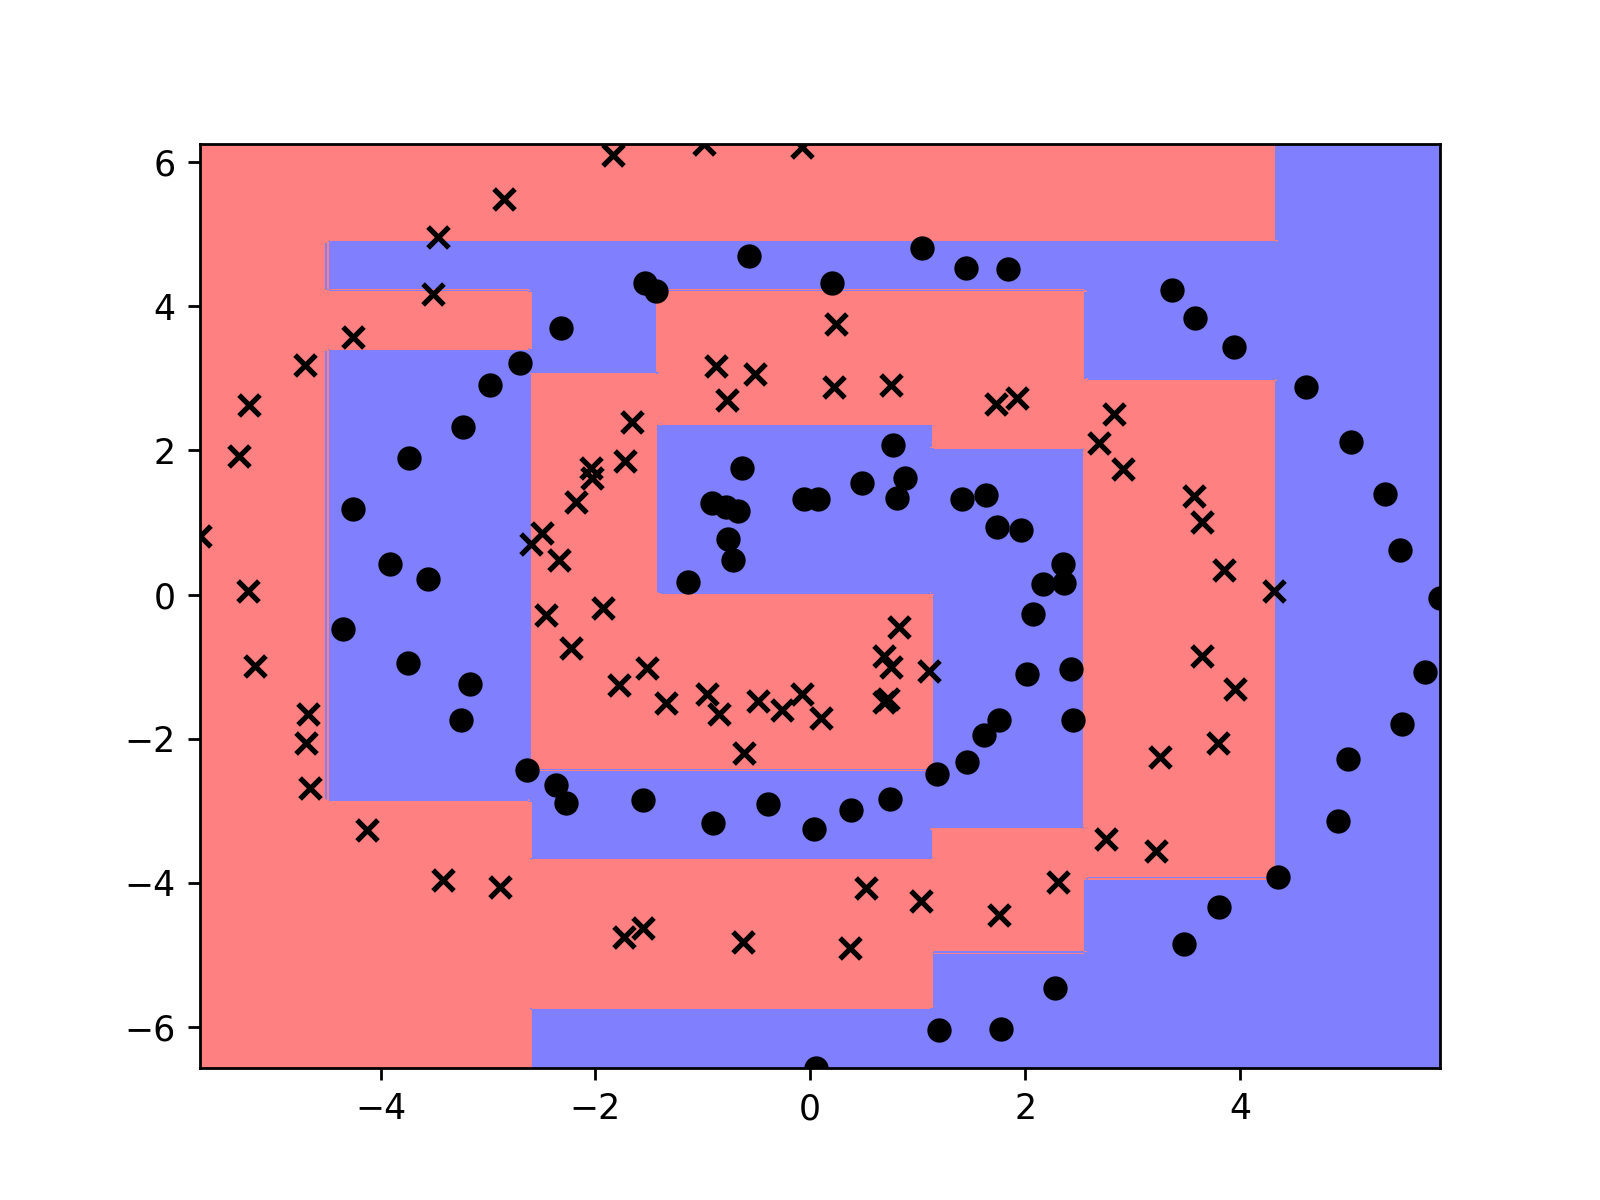

Training error: 0.0000
Testing error:  0.0333


In [73]:
tree = cart(xTrSpiral,yTrSpiral)
visclassifier(lambda X: evaltree(tree,X), xTrSpiral, yTrSpiral)


print("Training error: %.4f" % np.mean(np.sign(evaltree(tree,xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(evaltree(tree,xTeSpiral)) != yTeSpiral))

## Interactive Decision Boundary

In [83]:
def onclick_cart(event):
    """
    Visualize cart, including new point
    """
    global xTraining,labels
    # create position vector for new point
    pos=np.array([[event.xdata,event.ydata]]) 
    if event.key == 'shift': # add positive point
        color='or'
        label=1
    else: # add negative point
        color='ob'
        label=-1    
    xTraining = np.concatenate((xTraining,pos), axis = 0)
    labels.append(label);
    marker_symbols = ['o', 'x']
    classvals = np.unique(labels)
        
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    
    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(0, 1,res)
    yrange = np.linspace(0, 1,res)

    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # get decision tree
    tree = cart(xTraining,np.array(labels).flatten())
    fun = lambda X:evaltree(tree,X)
    # test all of these points on the grid
    testpreds = fun(xTe)
    
    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    
    plt.cla()    
    plt.xlim((0,1))
    plt.ylim((0,1))
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)
    
    for idx, c in enumerate(classvals):
        plt.scatter(xTraining[labels == c,0],
            xTraining[labels == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    plt.show()

<IPython.core.display.Javascript object>


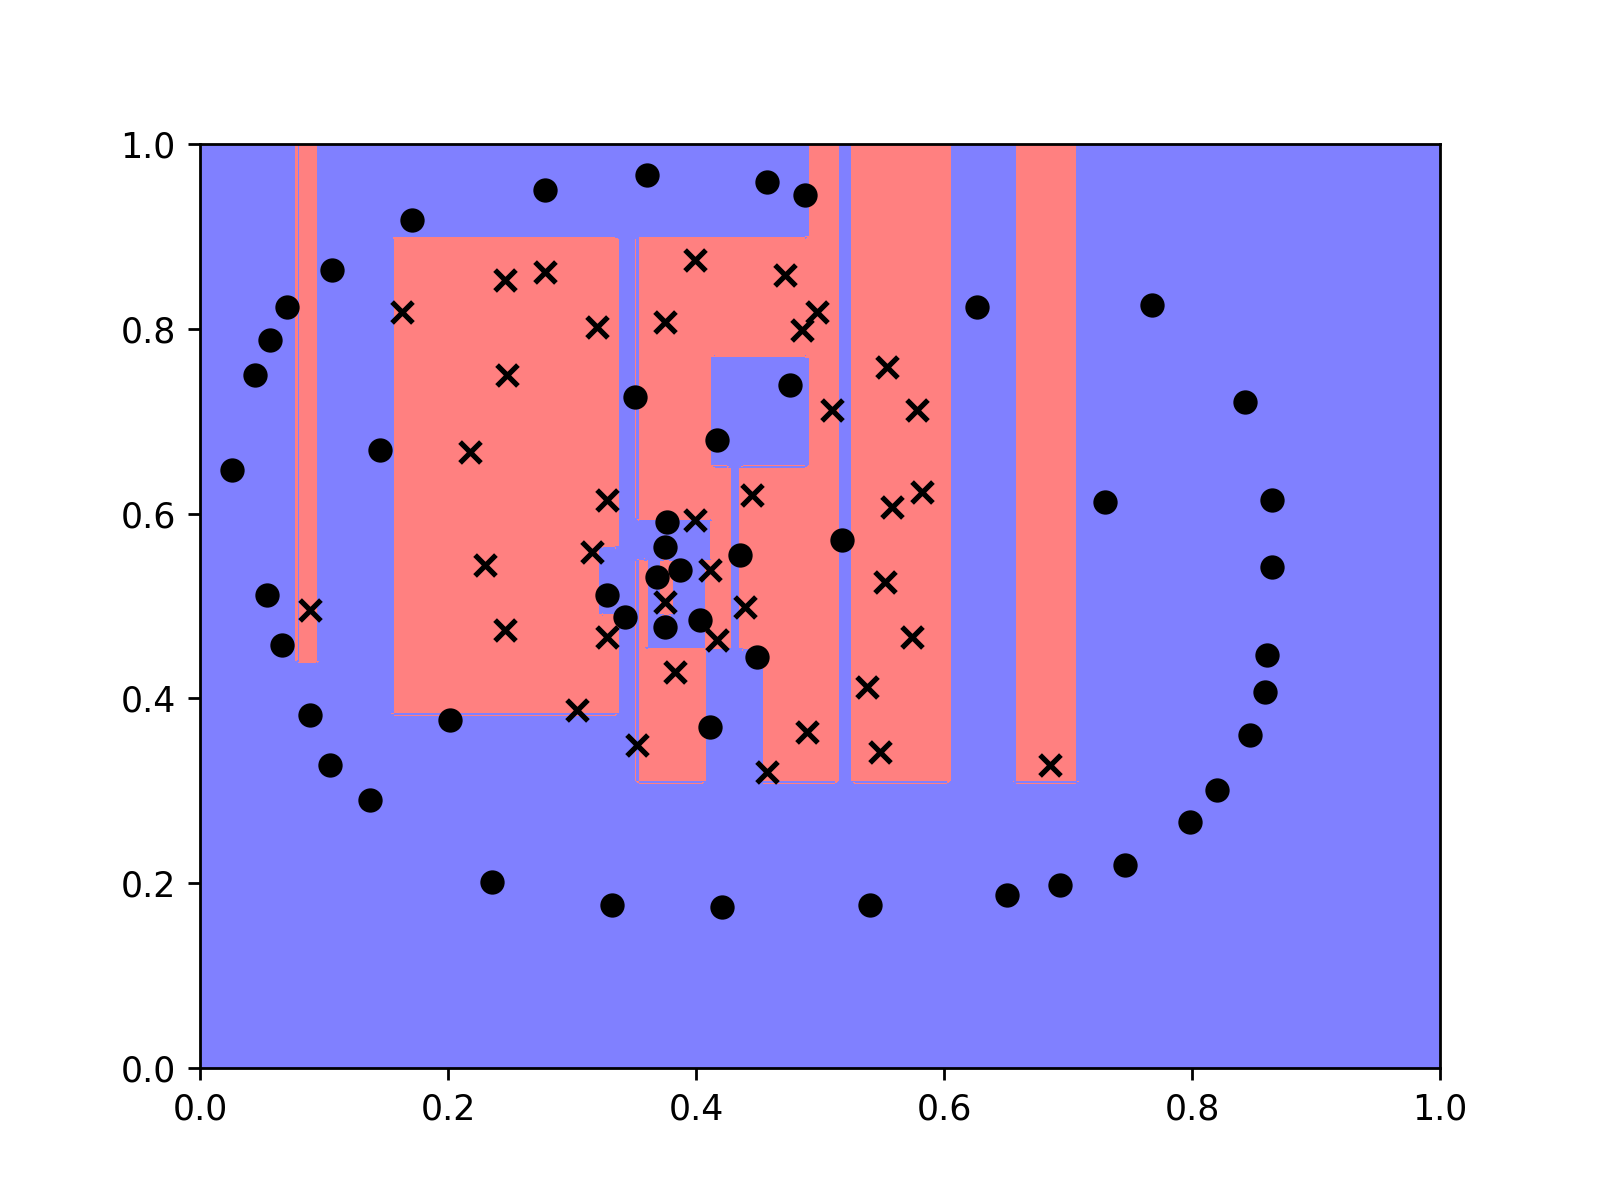

Text(0.5, 1.0, 'Use shift-click to add negative points.')

In [84]:
xTraining= np.array([[5,6]])
labels = [1]
%matplotlib notebook
fig = plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)
cid = fig.canvas.mpl_connect('button_press_event', onclick_cart)
plt.title('Use shift-click to add negative points.')

## Random Forest

CART trees are known to be **high variance** classifiers (especially when trained to **full depth**). 

An effective way to **prevent overfitting** is to use **bagging**: builds a forest of trees. Each tree should be trained on **randomly sampled $n$ examples** from the training data **with replacement**.

Note: here we do not **randomly sample features** (which could also **improve generalization** when there is a huge number of features).

In [74]:
def forest(xTr, yTr, m, maxdepth=np.inf):
    """
    Creates a random forest.
    Input:
        xTr:      n x d matrix of data points
        yTr:      n-dimensional vector of labels
        m:        number of trees in the forest
        maxdepth: maximum depth of tree
    Output:
        trees: list of TreeNode decision trees of length m
    """
    
    n, d = xTr.shape
    trees = []
    
    for i in range(m):
        idx = np.random.choice(n, size=n, replace=True)
        tree = cart(xTr[idx], yTr[idx], depth=maxdepth)
        trees.append(tree)
    
    return trees

Now, we define a function to **evaluate** the forest by computed the **weighted average** of the predictions of the $m$ trees. For random forests, we define the weights to be $\frac{1}{m}$ for all trees.

In [75]:
def evalforest(trees, X, alphas=None):
    """
    Evaluates X using trees.
    Input:
        trees:  list of TreeNode decision trees of length m
        X:      n x d matrix of data points
        alphas: m-dimensional weight vector
    Output:
        pred: n-dimensional vector of predictions
    """
    
    m = len(trees)
    n,d = X.shape
    if alphas is None:
        alphas = np.ones(m) / len(trees)
            
    pred = np.zeros(n)
    
    for i in range(m):
        pred += evaltree(trees[i], X) * alphas[i]
    
    return pred

Let's visualize the decision boundary of the random forest:

<IPython.core.display.Javascript object>


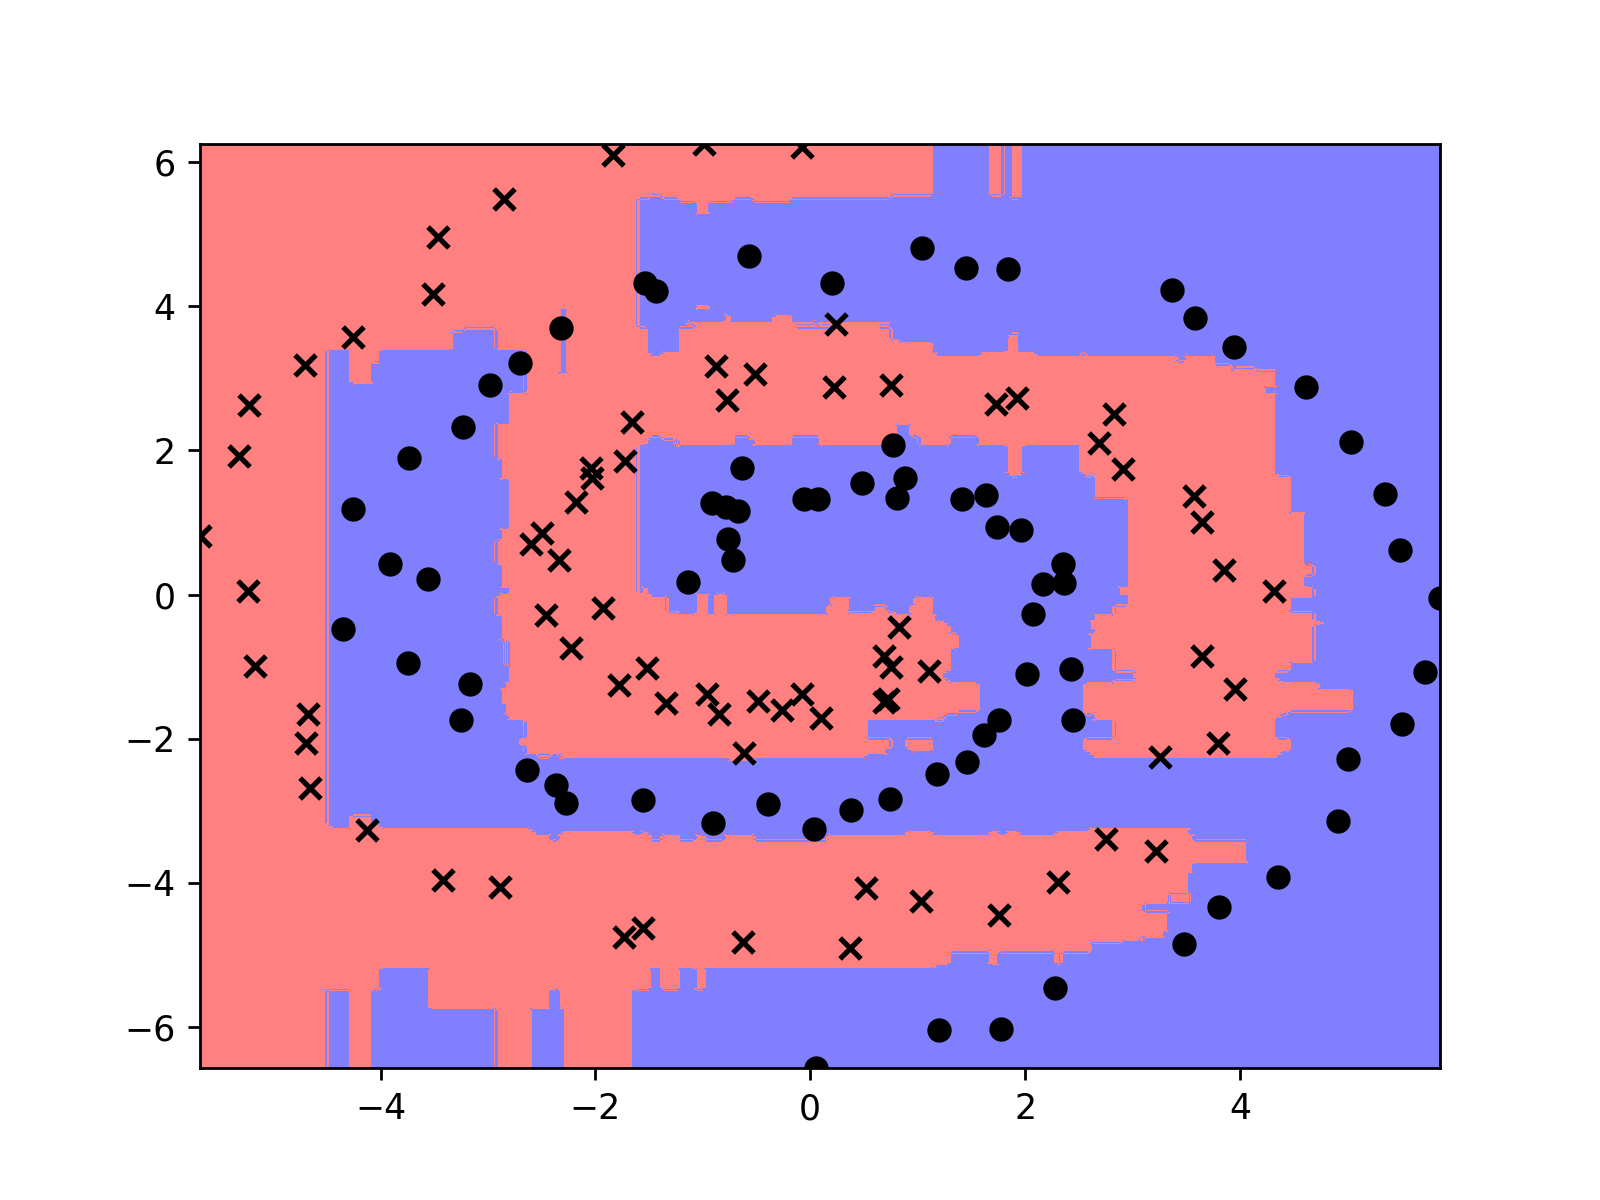

Training error: 0.0000
Testing error:  0.0333


In [76]:
trees = forest(xTrSpiral, yTrSpiral, 30)
visclassifier(lambda X: evalforest(trees,X), xTrSpiral, yTrSpiral)

print("Training error: %.4f" % np.mean(np.sign(evaltree(tree,xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(evaltree(tree,xTeSpiral)) != yTeSpiral))

Let's now evaluate the performance of the random forest classifier with **different number of trees**:

[0]training err = 0.0733	testing err = 0.2000
[1]training err = 0.1067	testing err = 0.2267
[2]training err = 0.0200	testing err = 0.1467
[3]training err = 0.0133	testing err = 0.1467
[4]training err = 0.0067	testing err = 0.1333
[5]training err = 0.0133	testing err = 0.1200
[6]training err = 0.0133	testing err = 0.1267
[7]training err = 0.0067	testing err = 0.1267
[8]training err = 0.0000	testing err = 0.1067
[9]training err = 0.0133	testing err = 0.1000
[10]training err = 0.0000	testing err = 0.0667
[11]training err = 0.0067	testing err = 0.0867
[12]training err = 0.0000	testing err = 0.0800
[13]training err = 0.0000	testing err = 0.0933
[14]training err = 0.0000	testing err = 0.0733
[15]training err = 0.0000	testing err = 0.0867
[16]training err = 0.0000	testing err = 0.0800
[17]training err = 0.0000	testing err = 0.0667
[18]training err = 0.0000	testing err = 0.0600
[19]training err = 0.0000	testing err = 0.0600


<IPython.core.display.Javascript object>


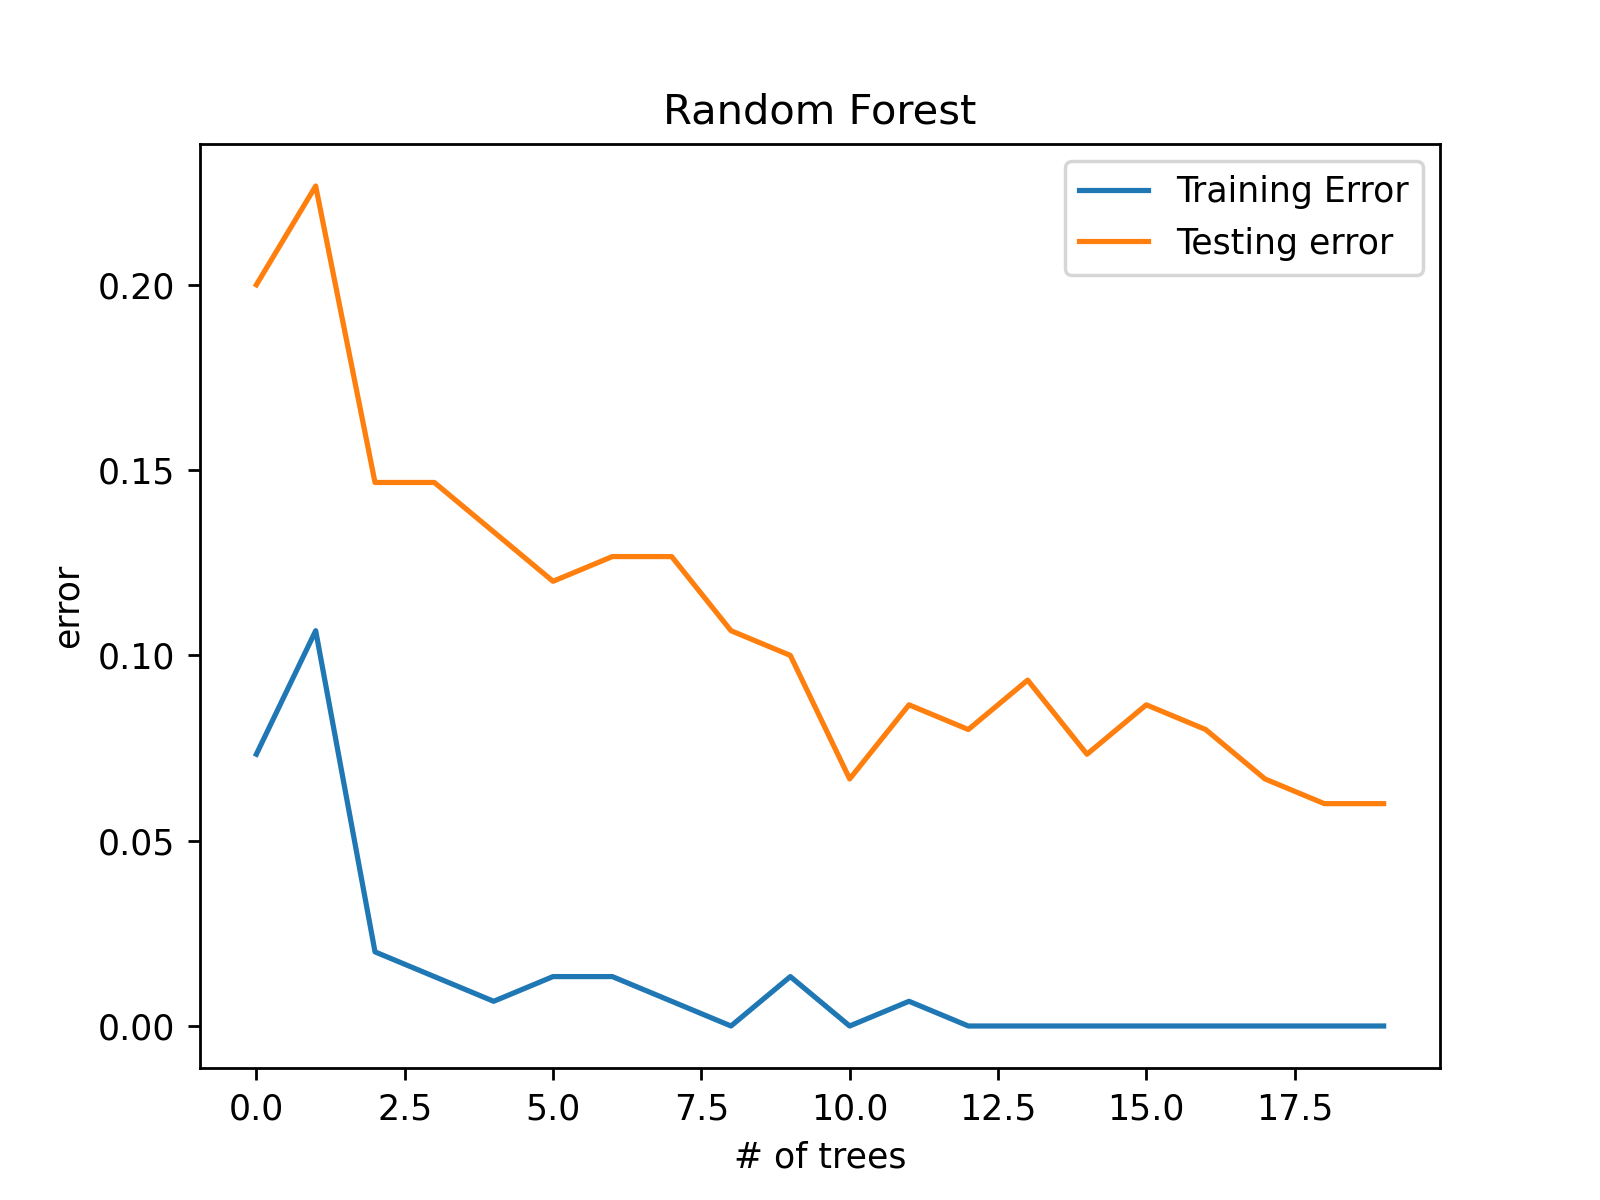

In [80]:
M = 20
err_trB = []
err_teB = []
alltrees = forest(xTrSpiral, yTrSpiral, M)

for i in range(M):
    trees=alltrees[:i+1]
    trErr = np.mean(np.sign(evalforest(trees, xTrSpiral)) != yTrSpiral)
    teErr = np.mean(np.sign(evalforest(trees, xTeSpiral)) != yTeSpiral)
    err_trB.append(trErr)
    err_teB.append(teErr)
    print("[%d]training err = %.4f\ttesting err = %.4f" % (i,trErr, teErr))

plt.figure()
line_tr, = plt.plot(range(M), err_trB, label="Training Error")
line_te, = plt.plot(range(M), err_teB, label="Testing error")
plt.title("Random Forest")
plt.legend(handles=[line_tr, line_te])
plt.xlabel("# of trees")
plt.ylabel("error")
plt.show()

## Boosting

Another option to **improve the generalization** of decision trees is to build trees of **small depth** (e.g. max_depth = 3 or 4).

Shallow trees do not have high variance, but instead suffer from **high bias**. To reduce the bias, we can use **boosting**. Here, we try to implement the **AdaBoost** method.

The key idea of the **Adaptive Boosting** is to train multiple **weak learners** sequentially with **increasing weights** of the previously misclassified samples.

>**Steps** of the AdaBoost method:
>
>1. Given a **training set**:
>
>$$S = \{(x_i,y_i): x_i \in R^d, y_i \in \{-1,+1\}, i=1,...,m\}$$
>
>2. Start with **uniform weights** for the training points:
>
>$$W_t = \{w_i: w_0=w_1=...=w_m=\frac{1}{m}\}$$
>
>For $t=1,2,...,T$: ($T$ is the maximum number of trees)
>
>3. Train a **stump** (a single-split tree) $h_t$ on $S$ with the weight $W_t$
>4. Use the stump to make **predictions**:
>
>$$h_t(x_i)=sign[f_t(x_i)]$$ 
>
>5. Compute the **weighted training error**:
>
>$$\epsilon_t=\sum^{m}_{i=1}w_iI[h_t(x_i) \neq y_i]$$
>
>(end the iteration if $\epsilon_t<\frac{1}{2}$)
>
>6. Compute the **stump weight** for this classifier based on its training error:
>
>$$\alpha_t=\frac{1}{2}\log(\frac{1-\epsilon_t}{\epsilon_t})$$
>
>7. **Update the weights** of the training points based on whether they have been misclassified:
>
>$$W_{t+1}=W_{t}*\frac{e^{\alpha_tyh_t(x)}}{Z_t}=W_{t}*\frac{e^{\alpha_tyh_t(x)}}{2\sqrt{\epsilon_t(1-\epsilon_t)}}$$
>
>8. Train another **stump** $h_{t+1}$ on $S$ with the updated weight $W_{t+1}$...

>The **final prediction** of the AdaBoost algorithm is given as:
>
>$$H(x)=sign[F(x)]=sign[\sum^{T}_{t=1}\alpha_th_t(x)]$$

>We have the **normalization term**:
>
>$$Z_t=2\sqrt{\epsilon(1-\epsilon)}$$
>
>so that the **upper bound** of the **classification error** $\frac{1}{m}\sum^{m}_{i=1}H(x_i) \neq y_i$ is **minimized**.
>
>After $t$ steps, the **error rate** is bounded on top by:
>
>$$Err(H) \leq Z \leq \exp(-2\sum^{T}_{t=1}{\gamma_t}^2)$$
>
>where $\gamma_t=\frac{1}{2}-\epsilon_t(h_t)$. Hence, each step decreases the upper bound **exponentially**.

>To ensures that the **weight** for each weak classifier is **positive**:
>
>$$\alpha_t=\frac{1}{2}\log(\frac{1-\epsilon_t}{\epsilon_t})>0$$
>
>We need to have the **training error** fullfills $\epsilon_t<\frac{1}{2}$.

In [89]:
def boosttree(x,y,maxiter=100,maxdepth=2):
    """
    Learns a boosted decision tree.
    Input:
        x:        n x d matrix of data points
        y:        n-dimensional vector of labels
        maxiter:  maximum number of trees
        maxdepth: maximum depth of a tree 
    Output:
        forest: list of TreeNode decision trees of length m
        alphas: m-dimensional weight vector
    """
    
    assert np.allclose(np.unique(y), np.array([-1,1])); #the labels must be -1 and 1 
    
    n, d = x.shape
    weights = np.ones(n) / n
    
    preds   = None
    forest  = []
    alphas  = []

    for t in range(maxiter):

        tree = cart(x, y, maxdepth, weights)
        f = evaltree(tree, x)
        h = np.sign(f)
        error = np.sum(weights[(h!=y)])
        
        if error < 0.5:
            forest.append(tree)
            alpha = 0.5*np.log((1-error)/error)
            alphas.append(alpha)
            weights = weights*np.exp(-alpha*y*h)/(2*(np.sqrt(error*(1-error))))
        else:
            break
    
    return forest, alphas

[0] exp loss = 0.9841 training err = 0.4333	testing err = 0.4333
[1] exp loss = 0.9589 training err = 0.4067	testing err = 0.4133
[2] exp loss = 0.9345 training err = 0.4067	testing err = 0.4133
[3] exp loss = 0.9175 training err = 0.3333	testing err = 0.3600
[4] exp loss = 0.8906 training err = 0.2533	testing err = 0.3200
[5] exp loss = 0.8735 training err = 0.2333	testing err = 0.2800
[6] exp loss = 0.8536 training err = 0.2467	testing err = 0.3000
[7] exp loss = 0.8457 training err = 0.2867	testing err = 0.3333
[8] exp loss = 0.8375 training err = 0.2600	testing err = 0.3267
[9] exp loss = 0.8292 training err = 0.2867	testing err = 0.3333
[10] exp loss = 0.8226 training err = 0.2267	testing err = 0.3000
[11] exp loss = 0.8156 training err = 0.2800	testing err = 0.3333
[12] exp loss = 0.8099 training err = 0.2400	testing err = 0.3067
[13] exp loss = 0.8071 training err = 0.2400	testing err = 0.3067
[14] exp loss = 0.8026 training err = 0.2267	testing err = 0.3000
[15] exp loss = 0.78

<IPython.core.display.Javascript object>


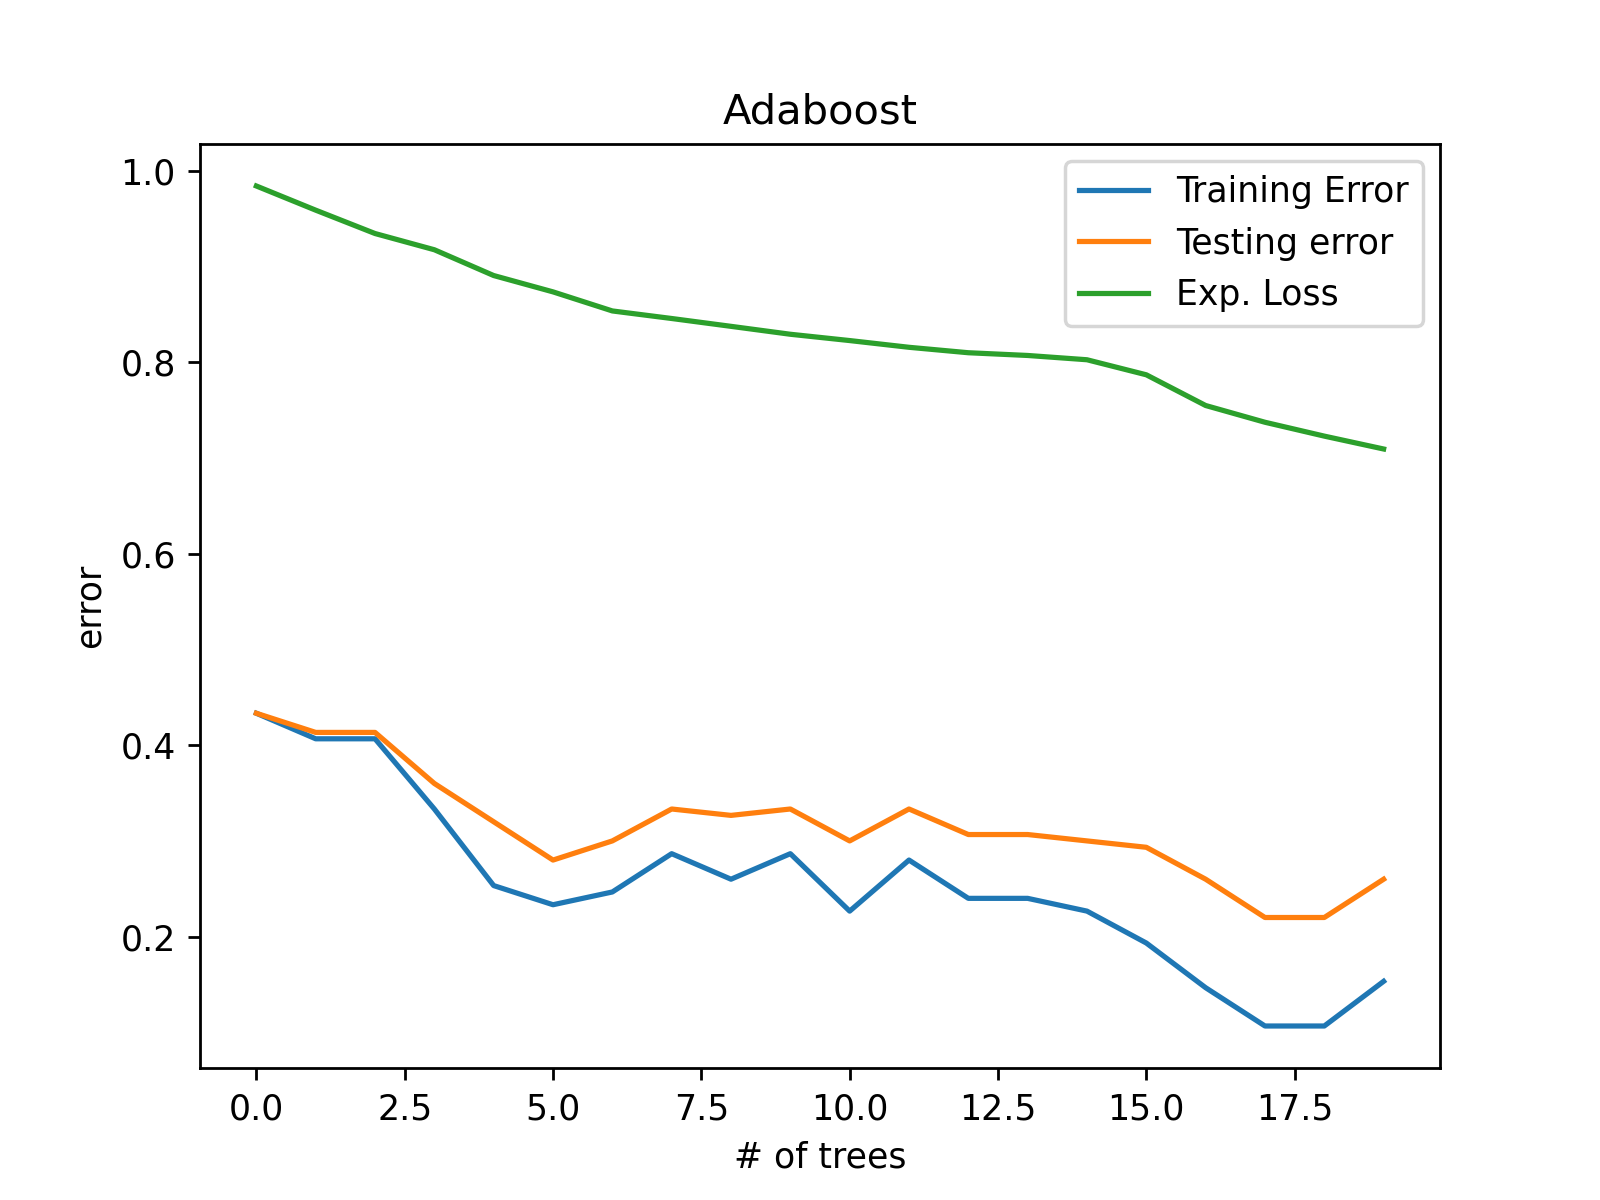

In [90]:
M = 20
alltrees, allalphas = boosttree(xTrSpiral, yTrSpiral, maxdepth=3, maxiter=M)

err_trB = []
loss_trB = []
err_teB = []

for i in range(M):
    trees = alltrees[:i+1]
    alphas = allalphas[:i+1]
    trErr = np.mean(np.sign(evalforest(trees,xTrSpiral,alphas)) != yTrSpiral)
    trLoss = np.mean(np.exp(-evalforest(trees,xTrSpiral,alphas)*yTrSpiral))
    teErr = np.mean(np.sign(evalforest(trees,xTeSpiral,alphas)) != yTeSpiral)
    err_trB.append(trErr)
    err_teB.append(teErr)
    loss_trB.append(trLoss)
    print("[%d] exp loss = %.4f training err = %.4f\ttesting err = %.4f" % (i, trLoss, trErr, teErr))

plt.figure()
line_tr, = plt.plot(range(M), err_trB, label="Training Error")
line_te, = plt.plot(range(M), err_teB, label="Testing error")
line_trloss, = plt.plot(range(M), loss_trB, label='Exp. Loss')
plt.title("Adaboost")
plt.legend(handles=[line_tr, line_te,line_trloss])
plt.xlabel("# of trees")
plt.ylabel("error")
plt.show()